 # Predicción de series temporales
 
 Este código acompaña al siguiente [post](sensioai.com/blog/series-temporales).

## Datos

Vamos a generar series temporales aleatorias.

In [29]:
import numpy as np

def generate_time_series(bs, n):
    f1, f2, o1, o2 = np.random.rand(4, bs, 1)
    t = np.linspace(0, 1, n)
    s = 0.5 * np.sin((t - o1) * (f1 * 10 + 10)) 
    s += 0.2 * np.sin((t - o2) * (f2 * 20 + 20))
    s += 0.1 * (np.random.rand(bs, n) - 0.5)  
    return s[..., np.newaxis].astype(np.float32)

n = 50
s = generate_time_series(10000, n + 1)
X_train, y_train = s[:7000, :n], s[:7000, -1]
X_val, y_val = s[7000:9000, :n], s[7000:9000, -1]
X_test, y_test = s[9000:, :n], s[9000:, -1]
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([1]))

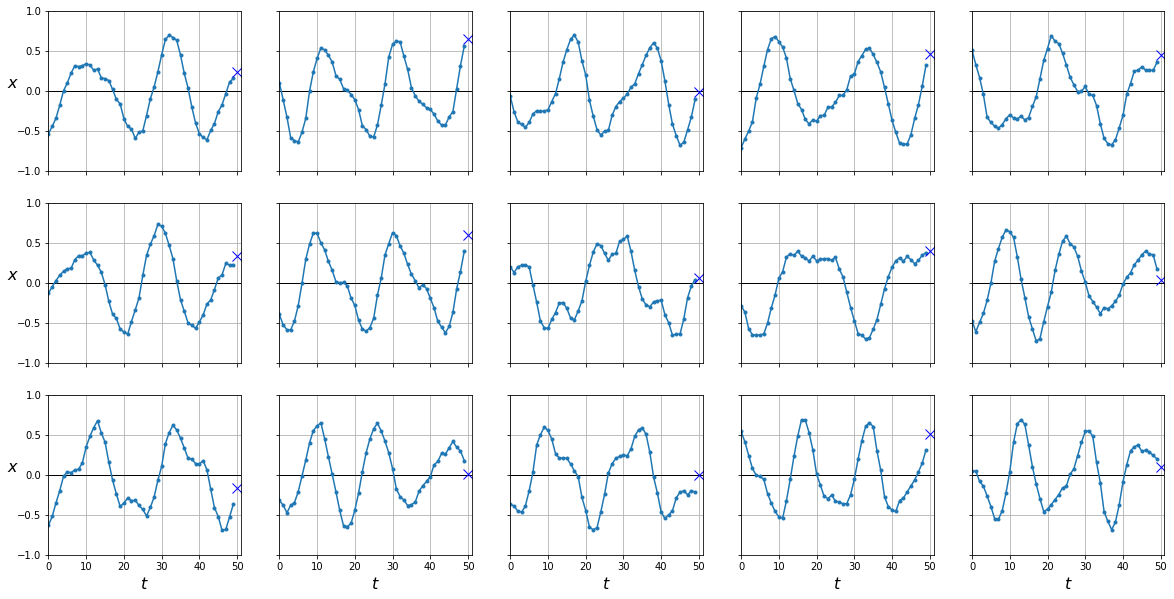

In [31]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_train, y_train)

## Modelo simple

Un modelo simple consiste en predecir siempre el último valor.

In [32]:
from sklearn.metrics import mean_squared_error

y_pred = X_val[:,-1]
mean_squared_error(y_val, y_pred)

0.020827362

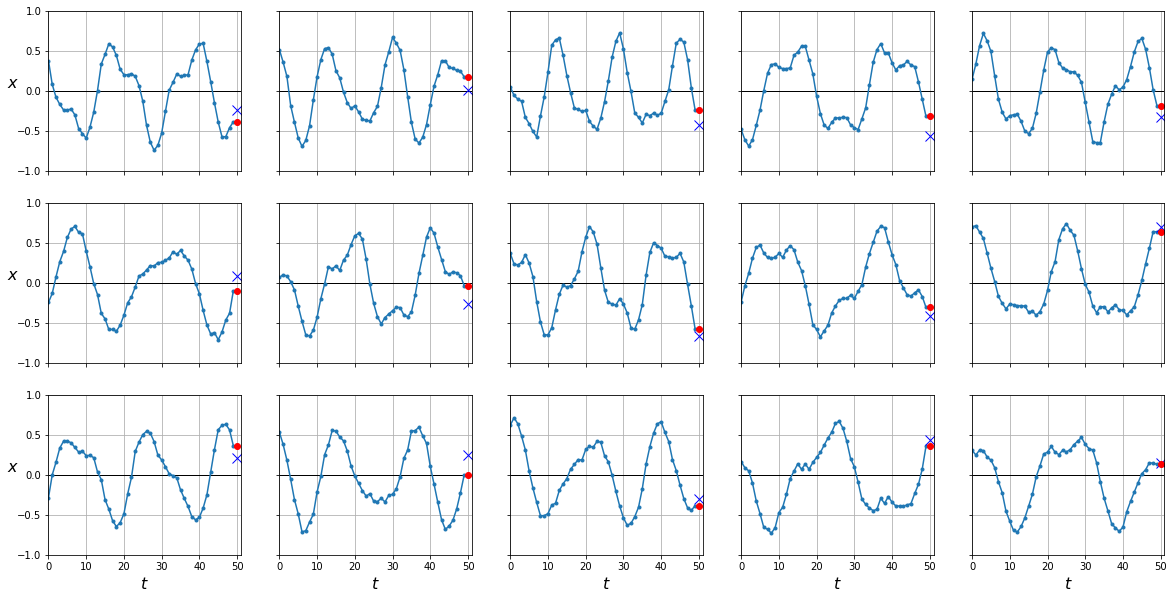

In [33]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

## Preceptrón

In [72]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

class Perceptron(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

model = Perceptron()
model.to(device)

Perceptron(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [73]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), \
                torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])
    
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'val': TimeSeriesDataset(X_val, y_val),
    'test': TimeSeriesDataset(X_test, y_test)
}

bs = 64
dataloader = {
    'train': DataLoader(dataset['train'], 
                        shuffle=True, 
                        batch_size=bs),
    'val': DataLoader(dataset['val'], batch_size=bs),
    'test': DataLoader(dataset['test'], batch_size=bs)
}

In [74]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()      

In [75]:
epochs = 10
for e in range(1, epochs+1):
    model.train()
    train_loss = []
    for batch in dataloader['train']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in dataloader['val']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss.append(loss.item())
    print(f'Epoch {e}/{epochs} \
        loss {np.mean(train_loss):.4f} \
        val_loss {np.mean(val_loss):.4f}')

Epoch 1/10         loss 0.1487         val_loss 0.0808
Epoch 2/10         loss 0.0648         val_loss 0.0486
Epoch 3/10         loss 0.0419         val_loss 0.0346
Epoch 4/10         loss 0.0305         val_loss 0.0261
Epoch 5/10         loss 0.0236         val_loss 0.0210
Epoch 6/10         loss 0.0192         val_loss 0.0178
Epoch 7/10         loss 0.0164         val_loss 0.0157
Epoch 8/10         loss 0.0146         val_loss 0.0141
Epoch 9/10         loss 0.0131         val_loss 0.0128
Epoch 10/10         loss 0.0121         val_loss 0.0118


In [76]:
model.eval()
test_loss = []
with torch.no_grad():
    for batch in dataloader['test']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        test_loss.append(loss.item())
print(f'test_loss {np.mean(test_loss):.4f}')

test_loss 0.0111


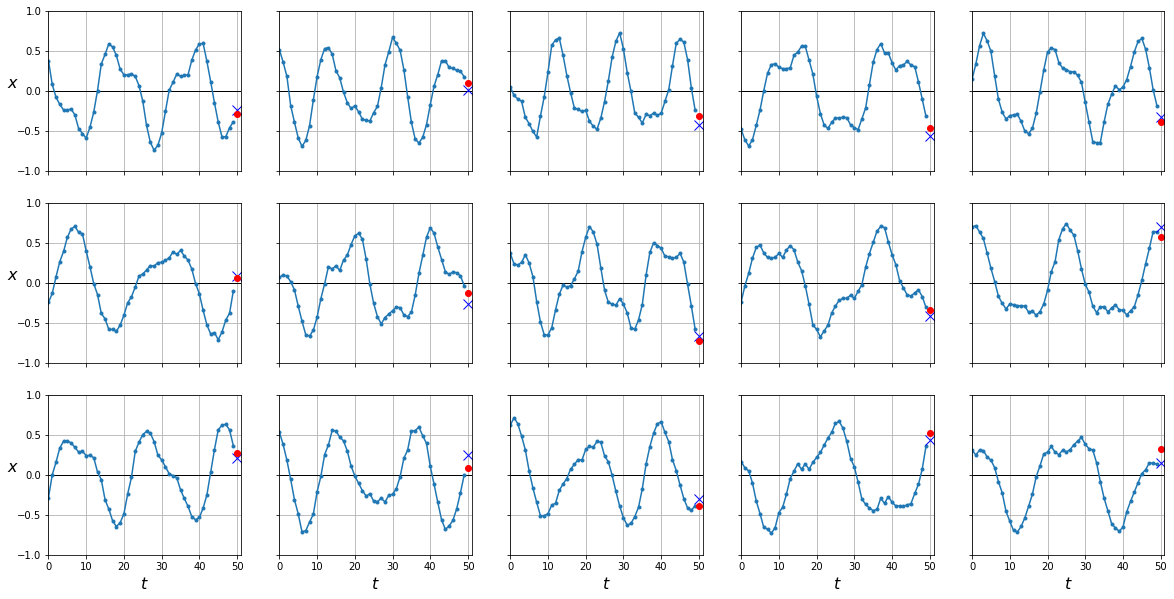

In [77]:
y_pred = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
    for batch in dataloader['test']:
        X, _ = batch
        X = X.to(device)
        output = model(X)
        y_pred = torch.cat((y_pred, output))

plot_series(X_test, y_test, y_pred.cpu().numpy())

## Redes Recurrentes

In [85]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, 
                            hidden_size=1, 
                            num_layers=1, 
                            batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # devolver el último output
    return x[:,-1]

model = SimpleRNN()
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [86]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [87]:
epochs = 10
for e in range(1, epochs+1):
    model.train()
    train_loss = []
    for batch in dataloader['train']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in dataloader['val']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss.append(loss.item())
    print(f'Epoch {e}/{epochs} \
        loss {np.mean(train_loss):.4f} \
        val_loss {np.mean(val_loss):.4f}')

Epoch 1/10         loss 0.2565         val_loss 0.1848
Epoch 2/10         loss 0.1583         val_loss 0.1354
Epoch 3/10         loss 0.1219         val_loss 0.1096
Epoch 4/10         loss 0.0983         val_loss 0.0885
Epoch 5/10         loss 0.0788         val_loss 0.0708
Epoch 6/10         loss 0.0631         val_loss 0.0575
Epoch 7/10         loss 0.0526         val_loss 0.0491
Epoch 8/10         loss 0.0459         val_loss 0.0441
Epoch 9/10         loss 0.0418         val_loss 0.0405
Epoch 10/10         loss 0.0386         val_loss 0.0377


In [88]:
model.eval()
test_loss = []
with torch.no_grad():
    for batch in dataloader['test']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        test_loss.append(loss.item())
print(f'test_loss {np.mean(test_loss):.4f}')

test_loss 0.0382


In [89]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn1 = torch.nn.RNN(input_size=1, 
                             hidden_size=20, 
                             num_layers=2, 
                             batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn1(x) 
    x = self.fc(x[:,-1])
    return x

model = DeepRNN()
model.to(device)

DeepRNN(
  (rnn1): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [90]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [91]:
epochs = 10
for e in range(1, epochs+1):
    model.train()
    train_loss = []
    for batch in dataloader['train']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in dataloader['val']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss.append(loss.item())
    print(f'Epoch {e}/{epochs} \
        loss {np.mean(train_loss):.4f} \
        val_loss {np.mean(val_loss):.4f}')

Epoch 1/10         loss 0.0529         val_loss 0.0123
Epoch 2/10         loss 0.0068         val_loss 0.0058
Epoch 3/10         loss 0.0049         val_loss 0.0048
Epoch 4/10         loss 0.0043         val_loss 0.0045
Epoch 5/10         loss 0.0040         val_loss 0.0045
Epoch 6/10         loss 0.0037         val_loss 0.0038
Epoch 7/10         loss 0.0036         val_loss 0.0037
Epoch 8/10         loss 0.0034         val_loss 0.0037
Epoch 9/10         loss 0.0034         val_loss 0.0035
Epoch 10/10         loss 0.0034         val_loss 0.0034


In [92]:
model.eval()
test_loss = []
with torch.no_grad():
    for batch in dataloader['test']:
        X, y = batch
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        test_loss.append(loss.item())
print(f'test_loss {np.mean(test_loss):.4f}')

test_loss 0.0038


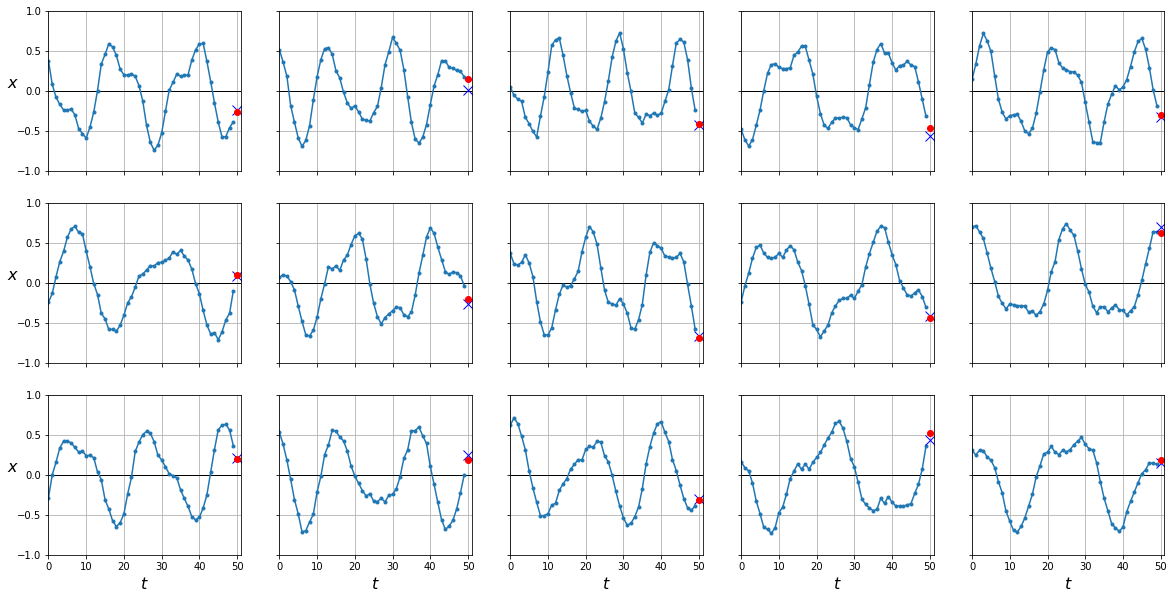

In [93]:
y_pred = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
    for batch in dataloader['test']:
        X, _ = batch
        X = X.to(device)
        output = model(X)
        y_pred = torch.cat((y_pred, output))

plot_series(X_test, y_test, y_pred.cpu().numpy())